## Recreate DQN model from Deepmind Atari paper

References:   
Paper: https://arxiv.org/pdf/1312.5602.pdf    
Pytorch tutorial: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

### Dependencies
gym==0.21.0     
torch==2.1.0.dev20230526

In [1]:
# import relevant packages
import torch
from collections import namedtuple, deque
import random
from torch import nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import gym
import pandas as pd
import numpy as np
import cv2
import os
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

### Experience Replay   
Data structure to store past experiences and sample some examples for training, the idea is to ***"alleviate the problems of correlated data and non-stationary distributions"***

In [2]:
# Use named tuple to represent Experience referred in paper
Experience = namedtuple('Experience', ["state", "action", "reward", "successor", "done"])

class ReplayMemory():
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
        
    def push(self, *args):
        """add new experience"""
        self.memory.append(Experience(*args))
        
    def sample(self, batch_size):
        """randomly sample experiences from Replay Memory"""
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        """Override default len() method"""
        return len(self.memory)

### Training Model  
Build model based on the paper's description 
> The input to the neural network consists is an 84 × 84 × 4 image produced by φ. The first hidden layer convolves **16 8 × 8 filters with stride 4** with the input image and applies a **rectifier nonlinearity**. The second hidden layer convolves **32 4 × 4 filters with stride 2**, again followed by a **rectifier nonlinearity**. The final hidden layer is fully-connected and consists of **256 rectifier units**. The output layer is a fully- connected linear layer with a **single output for each valid action**.

In [3]:
class DQN_model(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN_model, self).__init__()
        self.layer1 = nn.Conv2d(input_shape[0], 16, kernel_size=(8,8), stride=4)
        self.layer2 = nn.Conv2d(16, 32, (4,4), stride=2)
        # output shape after EACH convo would be ((dimension - filter size)/stride +1) **2 (for 2 sides)
                                                                            # * 4 (stack) * output_channel
        dim_size = (((84-8)/4 + 1)-4)/2+1
        self.layer3 = nn.Linear(int((dim_size)**2 * 32), 256)
        self.output = nn.Linear(256, n_actions) 
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.layer3(x))
        x = self.output(x)
        
        return x

### Prepare environment   
The paper specifies several preprocessing steps to apply to the raw frames
>210 × 160 pixel images with a 128 color palette, can be computationally demanding, so we apply a basic preprocessing step aimed at reducing the input dimensionality. The raw frames are preprocessed by first converting their RGB representation to **gray-scale** and **down-sampling it to a 110×84 image**. The final input representation is obtained by cropping an 84 × 84 region of the image that roughly captures the playing area.

Using gym, we can apply **GrayScaleObservation** wrapper to get gray-scale representation, and instead of cropping to game play section, a **resize wrapper** is applied

<br>

> For the experiments in this paper, the function φ from algorithm 1 applies this preprocessing to the **last 4 frames of a history and stacks them** to produce the input to the Q-function.

For this, we can apply **FrameStack** wrapper to get a stacks of 4 frames

<br>

> Since the scale of scores varies greatly from game to game, we fixed all positive rewards to be 1 and all negative rewards to be −1, leaving 0 rewards unchanged.


Lastly, we can apply **ClipReward** wrapper to crop reward to specified range
<br>

Observation shape:  (4, 84, 84)


A.L.E: Arcade Learning Environment (version 0.7.4+069f8bd)
[Powered by Stella]


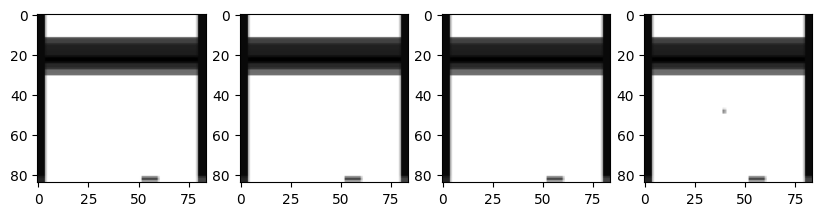

Low value 0.0 - High value 0.5803921818733215


In [4]:
from gym.wrappers import GrayScaleObservation, ResizeObservation, FrameStack, TransformObservation

# Wrapper to clip reward, taken from documentation
class ClipReward(gym.RewardWrapper):
    def __init__(self, env, min_reward, max_reward):
        super().__init__(env)
        self.min_reward = min_reward
        self.max_reward = max_reward
        self.reward_range = (min_reward, max_reward)
    
    def reward(self, reward):
        return np.clip(reward, self.min_reward, self.max_reward)
    
# observation wrapper for cropping
class AtariCropping(gym.ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops image"""
        super().__init__(env)
        
        old_shape = env.observation_space.shape
        # get new shape after cropping
        new_shape = (old_shape[0]-50,) + old_shape[1:]
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=new_shape)

    def observation(self, img):
        """what happens to each observation"""
        # crop image (top and bottom, top from 34, bottom remove last 16)
        img = img[34:-16, :, :]
        return img
    
class RescaleRange(gym.ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that rescale low and high value"""
        super().__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=env.observation_space.shape)

    def observation(self, img):
        """what happens to each observation"""
        # rescale value from range 0-255 to 0-1
        img = img.astype('float32') / 255.   
        return img

def generate_env(env_name):
    env = gym.make(env_name)
    env = ClipReward(env, -1, 1)
    env = AtariCropping(env)
    # gray scale frame
    env = GrayScaleObservation(env, keep_dim=False)
    env = RescaleRange(env)
    # resize frame to 84×84 image
    env = ResizeObservation(env, (84, 84))
    # stack 4 frames (equivalent to what phi does in paper) 
    env = FrameStack(env, num_stack=4)
    
    return env
    
env = generate_env("BreakoutDeterministic-v4")
env.reset()
observation, reward, done, _ = env.step(env.action_space.sample())
print("Observation shape: ", env.observation_space.shape)

# visualize frames in each step 
_, axs = plt.subplots(1, 4, figsize=(10,10))
for i, image in enumerate(observation):
    axs[i].imshow(image, cmap=plt.cm.binary)
plt.show()

print(f"Low value {np.min(np.asarray(observation))} - High value {np.max(np.asarray(observation))}")

### Function to determine action
Apply $\epsilon$ greedy algorithm to choose action   
* Choose random action at probability $\epsilon$
* Choose optimal action (determined by model) at probability (1-$\epsilon$)

In [5]:
import random

def choose_action(model, state, device, epsilon=0.001):
    if random.random()<=epsilon: #exploration
        return env.action_space.sample()
    else:
        with torch.no_grad():
    #         squeeze to remove last dim of 1 (for gray scaled val) and add 1 dim at first (1 input instead of batch)
            state = torch.Tensor(state).squeeze().unsqueeze(0).to(device)
            # predict
            pred = model(state)
            return int(torch.argmax(pred.squeeze()).item())

### Loss function  
As mentioned in the paper, the function to optimize would be the following
> $$L_i(θ_i) = E_{s,a∼ρ(·)} [(y_i − Q (s, a; θ_i))]^2 $$
> where: $$y_i = E_{s′∼\mathcal{E}} [r + γ max_{a′} Q(s′, a′; θ_{i−1})|s, a]$$

Notation translation:
- θ refers to weights of model, $θ_i$ refers to model (with weights) at iteration i
- $Q (s, a; θ_i)$ (prediction) is Q value at (s, a) estimated by model
- $y_i$ (target function) is calculated using Bellman equation, but future reward (aka Q(s', a')) is (again) estimated by the model

Code translation:
- $Q (s, a; θ_i)$ is calculated by plug in state for model to predict, and get the output at action a (state and action sampled from experience replay)
- $max_{a′} Q(s′, a′; θ_{i−1}$ in $y_i$ is calculated by plug in successor state, then get the max output out of all actions
- loss is square root of $y_i$ (expected Q) - $Q (s, a; θ_i)$ (prediction)

In [6]:
def loss_fn(model, replay_memory, batch_size, discount, target_model=None, device="mps"):
    batch = replay_memory.sample(batch_size)

#     Transpose batch, ref: https://stackoverflow.com/questions/19339/transpose-unzip-function-inverse-of-zip/19343#19343
    batch = Experience(*zip(*batch))
    
#     convert to a single np.array for faster tensor conversion
    state = np.array(batch.state)
    successor = np.array(batch.successor)
            
    # Tensor-ify state, action, reward, successor, done (use torch tensor to have grad)
    state = torch.Tensor(state).squeeze().to(device)
    action = torch.Tensor(batch.action).to(device)
    reward = torch.Tensor(batch.reward).to(device)
    successor = torch.Tensor(successor).squeeze().to(device)
    done = torch.tensor(batch.done, dtype=torch.int32).to(device)

    # use model to get old qs and successor qs
    old_qs = model(state)
    # if target model is provided -> use that to compute successor instead
    successor_qs = model(successor) if target_model is None else target_model(successor) 
    
#   check for exploding/diminissing problem
#     print(torch.isnan(old_qs).any())
        
    # get the list of actions in shape 1xbatch_size, and use it as indices for old_qs
    action = action.unsqueeze(1).type(torch.int64)
    # get predicted qs at action, return tensor of list of batch_size items
    old_qs = old_qs.gather(1, action).squeeze()
    # get max q in successor to estimate future reward
    successor_qs = successor_qs.max(1)[0]
            
    # compute expected qs
    # multiplying (1-done) would result in not adding future reward when at end state (done==1)
    expected_qs = reward + successor_qs*discount*(1-done)
    expected_qs = expected_qs.detach() # shouldnt include this in grad graph
        
    # compute loss, return mean loss of batch 
    loss = (expected_qs-old_qs).pow(2).mean()
    
#     print("Old Qs ", old_qs)
#     print("Expected Qs ", expected_qs)
#     print("Loss ", loss.item())
    
    # improvement for stability - use different loss 
    # loss_func = nn.HuberLoss()
    # loss = loss_func(old_qs, expected_qs)
    
    return loss

### Evaluation 
Evaluate model by let model plays in the env in 10000 steps, and return **average reward** and **predicted Q** value of a <u>held out set of states</u> 

In [9]:
from IPython import display
def generate_eval_states(env, no_states=1000, device="mps"):
    # TO BE MODIFIED
    states = [np.asarray(env.observation_space.sample()) for i in no_states]
    states = torch.Tensor(np.array(states)).squeeze().to(device)
    return states

def eval_model(model, env_id, eval_steps=10000, device="mps"):
    env=generate_env(env_id)
    curr_state = env.reset()
    curr_state = np.asarray(curr_state)
    
    episode_rewards = [0]
    
    for i in range(eval_steps):
        action = choose_action(model, curr_state, device, epsilon=0.05)
        
        observation, reward, done, _ = env.step(action)
        observation = np.asarray(observation) #convert to np array
        
        episode_rewards[-1]+=reward
        curr_state = observation
        
        if done:
            # end of episode -> reset env, create new total reward for episode
            curr_state = env.reset()
            curr_state = np.asarray(curr_state)
            episode_rewards.append(0)
            
    # calculate mean episode
    episode_reward = np.array(episode_rewards)
    return np.mean(episode_reward)
        
def plotting_util(xs, ys, avg_range=None):
    # plotting xs and ys
    # plot mean value of ys each avg_range step if avg_arange is provided (used to smooth out plot)
    
    if avg_range is not None:
        assert avg_range %len(xs)==0
        assert avg_range>0
        
        # create torch of size (n, avg_range) and find mean along each row (colapse shape[1])
        ys = torch.tensor(ys).view(-1, avg_range).mean(1)
        
        # colapse y to match new xs
        xs = torch.tensor(xs).view(-1, avg_range).max(1)[0]
    display.clear_output(wait=True)
    plt.plot(xs, ys)

### Parameters

In [11]:
# ------- Set up parameters -------
ENV = "BreakoutDeterministic-v4"
LOG_FREQ = 20 #number of EPISODES in-between logging results 
EVAL_FREQ = 50000 #number of STEPS before evaluate model
CHECKPOINT_FREQ = 100000 #number of STEPS before saving model
SAVE_DIR = "Breakout" #directory to save stuffs

# ------ Hyper parameters ---------
LEARNING_RATE = 0.00001 if ENV == "BreakoutDeterministic-v4" else 0.00025
REPLAY_LEN = 100000 # 1000000 in paper, but I still like mah laptop, so no
BATCH_SIZE = 32
EPISODES = 16000
DISCOUNT = 0.99 #aka gamma in Bellman's equation
START_EPSILON= 1
END_EPSILON= 0.1
DECAY_STEPS=1000000 # steps to decay epsilon
USE_TARGET_MODEL=True # whether to have target model or not
UPDATE_TARGET=1000 #steps to run before updating the target model

### Setting up variables before training

In [12]:
# ------- Set up device, check for mps, cuda or cpu -----------
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# ------- Set up env ----------------
env = generate_env(ENV)
print(f"Current Atari environment: {ENV}")
print(f"Learning rate: {LEARNING_RATE}")

# ------- Set up model ----------------
model = DQN_model(env.observation_space.shape, env.action_space.n).to(device)
target_model = None
if USE_TARGET_MODEL:
    target_model = DQN_model(env.observation_space.shape, env.action_space.n).to(device)
    target_model.load_state_dict(model.state_dict())

# ------- Set up optimizer ----------------
# optimizer based on paper
# optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE)

# optimizer for first training (not-so-happy accident =)))
# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

# recommended (less computational heavy compared to RMSprop)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# ------- Set up stats tracker ----------------
# losses = []
# rewards = []
# eval_rewards = []
steps = 0 # no steps
epsilon = 1

# ------- Set up replay buffer ----------------
curr_state = env.reset()
curr_state = np.asarray(curr_state) #convert to np array
replay_memory = ReplayMemory(capacity=REPLAY_LEN)
for i in range(BATCH_SIZE):
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)
    
    observation = np.asarray(observation) #convert to np array
    replay_memory.push(curr_state, action, reward, observation, done)
    
    # update curr state
    curr_state = observation
print(f"Initial length of replay memory: {len(replay_memory)}")

# ------- Set up saving dir ----------------
sub_folders = ["checkpoints", "tensorboard_runs"] # list of subfolders
for sub_folder in sub_folders:
    path = f"{SAVE_DIR}/{sub_folder}/"
    if not os.path.exists(path):
        # Create a new directory because it does not exist
        os.makedirs(path)
        print(f"{path} created")
        
# ------- Set up Tensorboard --------------
sample_input = replay_memory.sample(32)
#     Transpose 
sample_input = Experience(*zip(*sample_input))
#     convert to a single np.array for faster tensor conversion
sample_state = np.array(sample_input.state)
# Tensor-ify state, action, reward, successor, done
sample_state = torch.Tensor(sample_state).squeeze().to(device)

writer = SummaryWriter(log_dir=f"{SAVE_DIR}/tensorboard_runs/")
writer.add_graph(model, sample_state) # add graph for model

print(f'Start Tensorboard by running this command from project folder: tensorboard --logdir="{SAVE_DIR}/tensorboard_runs"')

Device: mps
Current Atari environment: BreakoutDeterministic-v4
Learning rate: 1e-05
Initial length of replay memory: 32
Breakout/tensorboard_runs/ created
Start Tensorboard by running this command from project folder: tensorboard --logdir="Breakout/tensorboard_runs"


### Training process

In [13]:
with tqdm(total=EPISODES, unit="episode") as pbar:

    # main training loop
    for i in range(EPISODES):
        curr_state = env.reset()
        curr_state = np.asarray(curr_state) #convert to np array
        loss_val = 0 # loss value for curr episode
        reward_val = 0 # reward value for curr episode
        # keep track of actions chosen during episode
        action_count = {i:0 for i in range(env.action_space.n)}

        while True:
        # ---------- Epsilon decay logic ------------
            # decay over the first million frames then stay at 0.1
            decay = (DECAY_STEPS - steps)/DECAY_STEPS if steps < DECAY_STEPS else 0
            epsilon = END_EPSILON + decay*(START_EPSILON-END_EPSILON)
            
        # ---------- Training steps logic ------------
            # execute action
            action = choose_action(model, curr_state, device, epsilon=epsilon)
            observation, reward, done, _ = env.step(action)
            observation = np.asarray(observation) #convert to np array
            # save observation
            replay_memory.push(curr_state, action, reward, observation, done)

            # update curr_state
            curr_state = observation

            # sample and compute loss
            loss = loss_fn(model, replay_memory, BATCH_SIZE, DISCOUNT, target_model=target_model, device=device)
            loss_item = loss.item()
            
            # zero out gradient before backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # ---------- Logging and update various stuffs ------------
            # update target model if available
            if USE_TARGET_MODEL:
                if steps%UPDATE_TARGET:
                    target_model.load_state_dict(model.state_dict())

            # update loss as the max loss during episode
            loss_val = max(loss_item, loss_val)
            # add steps count for epsilon decay
            steps+=1
            # update total reward of episode
            reward_val += reward
            # update action count
            action_count[action]+=1

            if steps%CHECKPOINT_FREQ==0:
                with open(f"{SAVE_DIR}/checkpoints/{steps}.pt", 'wb') as f:
                    torch.save(model.state_dict(), f)

            if steps%EVAL_FREQ==0:
                pbar.write("------- Evaluating --------")
                # eval steps
                eval_reward = eval_model(model, ENV, eval_steps=10000, device=device)   
#                 eval_rewards.append(eval_reward)
                pbar.write(f"Evaluation reward (average per episode) {eval_reward}")
                pbar.write("---------------------------")
                writer.add_scalar("Eval | Average reward/episode over Steps", eval_reward, steps)

            if done: 
                # finish an episode
                break
                
        # ------ Update training episode stats, use tqdm instead of printing -----
        pbar.update(1)
        pbar.set_description(desc=f"Ep: {i+1}|{steps} steps|Loss: {round(loss_val, 4)}|Reward: {reward_val}")
        
        # ------- Log training loss and training episode rewards for tensorboard
        if i%LOG_FREQ==0:
#             losses.append(loss_val)
#             rewards.append(reward_val)
            writer.add_scalars("Action Chosen in Episode", {"NOOP":action_count[0],
                                                        "FIRE":action_count[1], 
                                                        "RIGHT":action_count[2], 
                                                        "LEFT":action_count[3]}, i)
            writer.add_scalar("Train | Loss over Episode", loss_val, i)
            writer.add_scalar("Train | Reward over Episode", reward_val, i)
            
            
print("FINISH TRAINING PROCESS")
print(f"Finish in {steps} steps, Highest episode reward {max(rewards)}")

Ep: 282|49999 steps|Loss: 0.0909|Reward: 3.0:   2%| | 282/16000 [08:35<10:04:14,  2.31s/episo

------- Evaluating --------


Ep: 282|49999 steps|Loss: 0.0909|Reward: 3.0:   2%| | 282/16000 [08:51<10:04:14,  2.31s/episo

Evaluation reward (average per episode) 4.857142857142857
---------------------------


Ep: 559|99964 steps|Loss: 0.0554|Reward: 0.0:   3%| | 559/16000 [18:24<8:06:50,  1.89s/episod

------- Evaluating --------


Ep: 559|99964 steps|Loss: 0.0554|Reward: 0.0:   3%| | 559/16000 [18:40<8:06:50,  1.89s/episod

Evaluation reward (average per episode) 0.075
---------------------------


Ep: 827|149824 steps|Loss: 0.155|Reward: 2.0:   5%| | 827/16000 [28:53<11:17:02,  2.68s/episo

------- Evaluating --------


Ep: 827|149824 steps|Loss: 0.155|Reward: 2.0:   5%| | 827/16000 [29:09<11:17:02,  2.68s/episo

Evaluation reward (average per episode) 2.9166666666666665
---------------------------


Ep: 1080|199953 steps|Loss: 0.1491|Reward: 1.0:   7%| | 1080/16000 [39:18<8:36:16,  2.08s/epi

------- Evaluating --------


Ep: 1080|199953 steps|Loss: 0.1491|Reward: 1.0:   7%| | 1080/16000 [39:35<8:36:16,  2.08s/epi

Evaluation reward (average per episode) 3.0
---------------------------


Ep: 1323|249998 steps|Loss: 0.1673|Reward: 2.0:   8%| | 1323/16000 [49:48<9:22:08,  2.30s/epi

------- Evaluating --------


Ep: 1323|249998 steps|Loss: 0.1673|Reward: 2.0:   8%| | 1323/16000 [50:05<9:22:08,  2.30s/epi

Evaluation reward (average per episode) 2.875
---------------------------


Ep: 1557|299974 steps|Loss: 0.1624|Reward: 0.0:  10%| | 1557/16000 [1:00:01<8:01:43,  2.00s/e

------- Evaluating --------


Ep: 1557|299974 steps|Loss: 0.1624|Reward: 0.0:  10%| | 1557/16000 [1:00:17<8:01:43,  2.00s/e

Evaluation reward (average per episode) 1.3934426229508197
---------------------------


Ep: 1799|349871 steps|Loss: 0.1193|Reward: 4.0:  11%| | 1799/16000 [1:10:11<11:03:33,  2.80s/

------- Evaluating --------


Ep: 1800|350003 steps|Loss: 0.2269|Reward: 0.0:  11%| | 1800/16000 [1:10:27<28:32:13,  7.23s/

Evaluation reward (average per episode) 0.4722222222222222
---------------------------


Ep: 2031|399928 steps|Loss: 0.116|Reward: 0.0:  13%|▏| 2031/16000 [1:20:26<10:45:05,  2.77s/e

------- Evaluating --------


Ep: 2031|399928 steps|Loss: 0.116|Reward: 0.0:  13%|▏| 2031/16000 [1:20:42<10:45:05,  2.77s/e

Evaluation reward (average per episode) 1.2222222222222223
---------------------------


Ep: 2252|449926 steps|Loss: 0.1307|Reward: 5.0:  14%|▏| 2252/16000 [1:30:49<11:32:05,  3.02s/

------- Evaluating --------


Ep: 2252|449926 steps|Loss: 0.1307|Reward: 5.0:  14%|▏| 2252/16000 [1:31:05<11:32:05,  3.02s/

Evaluation reward (average per episode) 4.5
---------------------------


Ep: 2447|499988 steps|Loss: 0.1966|Reward: 3.0:  15%|▏| 2447/16000 [1:41:14<12:07:40,  3.22s/

------- Evaluating --------


Ep: 2447|499988 steps|Loss: 0.1966|Reward: 3.0:  15%|▏| 2447/16000 [1:41:31<12:07:40,  3.22s/

Evaluation reward (average per episode) 5.724137931034483
---------------------------


Ep: 2633|549969 steps|Loss: 0.0804|Reward: 2.0:  16%|▏| 2633/16000 [1:51:44<9:47:32,  2.64s/e

------- Evaluating --------


Ep: 2633|549969 steps|Loss: 0.0804|Reward: 2.0:  16%|▏| 2633/16000 [1:52:00<9:47:32,  2.64s/e

Evaluation reward (average per episode) 4.230769230769231
---------------------------


Ep: 2808|599571 steps|Loss: 0.2815|Reward: 7.0:  18%|▏| 2808/16000 [2:02:15<14:38:25,  4.00s/

------- Evaluating --------


Ep: 2808|599571 steps|Loss: 0.2815|Reward: 7.0:  18%|▏| 2808/16000 [2:02:31<14:38:25,  4.00s/

Evaluation reward (average per episode) 4.2894736842105265
---------------------------


Ep: 2987|649975 steps|Loss: 0.1712|Reward: 3.0:  19%|▏| 2987/16000 [2:12:53<11:34:53,  3.20s/

------- Evaluating --------


Ep: 2987|649975 steps|Loss: 0.1712|Reward: 3.0:  19%|▏| 2987/16000 [2:13:09<11:34:53,  3.20s/

Evaluation reward (average per episode) 4.885714285714286
---------------------------


Ep: 3161|699963 steps|Loss: 0.1431|Reward: 5.0:  20%|▏| 3161/16000 [2:23:33<12:44:46,  3.57s/

------- Evaluating --------


Ep: 3161|699963 steps|Loss: 0.1431|Reward: 5.0:  20%|▏| 3161/16000 [2:23:49<12:44:46,  3.57s/

Evaluation reward (average per episode) 3.658536585365854
---------------------------


Ep: 3327|749765 steps|Loss: 0.1943|Reward: 14.0:  21%|▏| 3327/16000 [2:34:18<17:40:28,  5.02s

------- Evaluating --------


Ep: 3327|749765 steps|Loss: 0.1943|Reward: 14.0:  21%|▏| 3327/16000 [2:34:33<17:40:28,  5.02s

Evaluation reward (average per episode) 6.137931034482759
---------------------------


Ep: 3473|799720 steps|Loss: 0.0857|Reward: 8.0:  22%|▏| 3473/16000 [2:45:10<17:03:26,  4.90s/

------- Evaluating --------


Ep: 3473|799720 steps|Loss: 0.0857|Reward: 8.0:  22%|▏| 3473/16000 [2:45:27<17:03:26,  4.90s/

Evaluation reward (average per episode) 7.3076923076923075
---------------------------


Ep: 3604|849692 steps|Loss: 0.1275|Reward: 5.0:  23%|▏| 3604/16000 [2:56:04<16:44:43,  4.86s/

------- Evaluating --------


Ep: 3604|849692 steps|Loss: 0.1275|Reward: 5.0:  23%|▏| 3604/16000 [2:56:20<16:44:43,  4.86s/

Evaluation reward (average per episode) 7.3076923076923075
---------------------------


Ep: 3734|899922 steps|Loss: 0.097|Reward: 7.0:  23%|▏| 3734/16000 [3:07:12<17:10:15,  5.04s/e

------- Evaluating --------


Ep: 3734|899922 steps|Loss: 0.097|Reward: 7.0:  23%|▏| 3734/16000 [3:07:28<17:10:15,  5.04s/e

Evaluation reward (average per episode) 6.0
---------------------------


Ep: 3857|949556 steps|Loss: 0.0964|Reward: 5.0:  24%|▏| 3857/16000 [3:18:28<17:06:26,  5.07s/

------- Evaluating --------


Ep: 3857|949556 steps|Loss: 0.0964|Reward: 5.0:  24%|▏| 3857/16000 [3:18:44<17:06:26,  5.07s/

Evaluation reward (average per episode) 8.291666666666666
---------------------------


Ep: 3976|999785 steps|Loss: 0.0733|Reward: 6.0:  25%|▏| 3976/16000 [3:29:47<18:22:51,  5.50s/

------- Evaluating --------


Ep: 3976|999785 steps|Loss: 0.0733|Reward: 6.0:  25%|▏| 3976/16000 [3:30:03<18:22:51,  5.50s/

Evaluation reward (average per episode) 8.565217391304348
---------------------------


Ep: 4087|1049744 steps|Loss: 0.1494|Reward: 15.0:  26%|▎| 4087/16000 [3:41:21<23:21:01,  7.06

------- Evaluating --------


Ep: 4087|1049744 steps|Loss: 0.1494|Reward: 15.0:  26%|▎| 4087/16000 [3:41:37<23:21:01,  7.06

Evaluation reward (average per episode) 10.2
---------------------------


Ep: 4194|1099863 steps|Loss: 0.1355|Reward: 11.0:  26%|▎| 4194/16000 [3:52:43<24:22:35,  7.43

------- Evaluating --------


Ep: 4194|1099863 steps|Loss: 0.1355|Reward: 11.0:  26%|▎| 4194/16000 [3:52:59<24:22:35,  7.43

Evaluation reward (average per episode) 9.909090909090908
---------------------------


Ep: 4298|1149543 steps|Loss: 0.1691|Reward: 12.0:  27%|▎| 4298/16000 [4:04:09<20:51:55,  6.42

------- Evaluating --------


Ep: 4298|1149543 steps|Loss: 0.1691|Reward: 12.0:  27%|▎| 4298/16000 [4:04:24<20:51:55,  6.42

Evaluation reward (average per episode) 11.444444444444445
---------------------------


Ep: 4397|1199994 steps|Loss: 0.0905|Reward: 11.0:  27%|▎| 4397/16000 [4:15:25<21:35:49,  6.70

------- Evaluating --------


Ep: 4397|1199994 steps|Loss: 0.0905|Reward: 11.0:  27%|▎| 4397/16000 [4:15:42<21:35:49,  6.70

Evaluation reward (average per episode) 11.31578947368421
---------------------------


Ep: 4498|1249661 steps|Loss: 0.0669|Reward: 9.0:  28%|▎| 4498/16000 [4:26:53<21:13:16,  6.64s

------- Evaluating --------


Ep: 4498|1249661 steps|Loss: 0.0669|Reward: 9.0:  28%|▎| 4498/16000 [4:27:09<21:13:16,  6.64s

Evaluation reward (average per episode) 11.631578947368421
---------------------------


Ep: 4599|1299559 steps|Loss: 0.1111|Reward: 10.0:  29%|▎| 4599/16000 [4:38:22<21:04:01,  6.65

------- Evaluating --------


Ep: 4599|1299559 steps|Loss: 0.1111|Reward: 10.0:  29%|▎| 4599/16000 [4:38:38<21:04:01,  6.65

Evaluation reward (average per episode) 10.238095238095237
---------------------------


Ep: 4695|1349838 steps|Loss: 0.1021|Reward: 14.0:  29%|▎| 4695/16000 [4:49:46<23:42:06,  7.55

------- Evaluating --------


Ep: 4695|1349838 steps|Loss: 0.1021|Reward: 14.0:  29%|▎| 4695/16000 [4:50:02<23:42:06,  7.55

Evaluation reward (average per episode) 12.0
---------------------------


Ep: 4785|1399877 steps|Loss: 0.1297|Reward: 12.0:  30%|▎| 4785/16000 [5:01:17<25:55:19,  8.32

------- Evaluating --------


Ep: 4785|1399877 steps|Loss: 0.1297|Reward: 12.0:  30%|▎| 4785/16000 [5:01:34<25:55:19,  8.32

Evaluation reward (average per episode) 11.88888888888889
---------------------------


Ep: 4876|1449857 steps|Loss: 0.1345|Reward: 13.0:  30%|▎| 4876/16000 [5:12:56<22:18:50,  7.22

------- Evaluating --------


Ep: 4876|1449857 steps|Loss: 0.1345|Reward: 13.0:  30%|▎| 4876/16000 [5:13:12<22:18:50,  7.22

Evaluation reward (average per episode) 11.894736842105264
---------------------------


Ep: 4964|1499589 steps|Loss: 0.1143|Reward: 13.0:  31%|▎| 4964/16000 [5:24:35<22:46:27,  7.43

------- Evaluating --------


Ep: 4964|1499589 steps|Loss: 0.1143|Reward: 13.0:  31%|▎| 4964/16000 [5:24:51<22:46:27,  7.43

Evaluation reward (average per episode) 13.625
---------------------------


Ep: 5050|1549866 steps|Loss: 0.1061|Reward: 14.0:  32%|▎| 5050/16000 [5:36:17<24:46:00,  8.14

------- Evaluating --------


Ep: 5050|1549866 steps|Loss: 0.1061|Reward: 14.0:  32%|▎| 5050/16000 [5:36:33<24:46:00,  8.14

Evaluation reward (average per episode) 13.764705882352942
---------------------------


Ep: 5136|1599925 steps|Loss: 0.1172|Reward: 9.0:  32%|▎| 5136/16000 [5:47:59<24:23:03,  8.08s

------- Evaluating --------


Ep: 5136|1599925 steps|Loss: 0.1172|Reward: 9.0:  32%|▎| 5136/16000 [5:48:15<24:23:03,  8.08s

Evaluation reward (average per episode) 12.941176470588236
---------------------------


Ep: 5223|1649879 steps|Loss: 0.1559|Reward: 10.0:  33%|▎| 5223/16000 [5:59:41<24:11:33,  8.08

------- Evaluating --------


Ep: 5223|1649879 steps|Loss: 0.1559|Reward: 10.0:  33%|▎| 5223/16000 [5:59:57<24:11:33,  8.08

Evaluation reward (average per episode) 13.0
---------------------------


Ep: 5305|1699572 steps|Loss: 0.1326|Reward: 13.0:  33%|▎| 5305/16000 [6:11:10<24:28:39,  8.24

------- Evaluating --------


Ep: 5305|1699572 steps|Loss: 0.1326|Reward: 13.0:  33%|▎| 5305/16000 [6:11:27<24:28:39,  8.24

Evaluation reward (average per episode) 14.375
---------------------------


Ep: 5388|1749699 steps|Loss: 0.1915|Reward: 12.0:  34%|▎| 5388/16000 [6:22:36<20:00:20,  6.79

------- Evaluating --------


Ep: 5388|1749699 steps|Loss: 0.1915|Reward: 12.0:  34%|▎| 5388/16000 [6:22:52<20:00:20,  6.79

Evaluation reward (average per episode) 15.4
---------------------------


Ep: 5466|1799548 steps|Loss: 0.2201|Reward: 18.0:  34%|▎| 5466/16000 [6:34:17<29:17:52, 10.01

------- Evaluating --------


Ep: 5466|1799548 steps|Loss: 0.2201|Reward: 18.0:  34%|▎| 5466/16000 [6:34:33<29:17:52, 10.01

Evaluation reward (average per episode) 15.6
---------------------------


Ep: 5547|1849203 steps|Loss: 0.1963|Reward: 21.0:  35%|▎| 5547/16000 [6:46:00<27:34:21,  9.50

------- Evaluating --------


Ep: 5547|1849203 steps|Loss: 0.1963|Reward: 21.0:  35%|▎| 5547/16000 [6:46:16<27:34:21,  9.50

Evaluation reward (average per episode) 17.214285714285715
---------------------------


Ep: 5624|1899852 steps|Loss: 0.1489|Reward: 16.0:  35%|▎| 5624/16000 [6:57:45<28:41:56,  9.96

------- Evaluating --------


Ep: 5624|1899852 steps|Loss: 0.1489|Reward: 16.0:  35%|▎| 5624/16000 [6:58:01<28:41:56,  9.96

Evaluation reward (average per episode) 12.88888888888889
---------------------------


Ep: 5702|1949340 steps|Loss: 0.1332|Reward: 9.0:  36%|▎| 5702/16000 [7:09:30<19:37:01,  6.86s

------- Evaluating --------


Ep: 5702|1949340 steps|Loss: 0.1332|Reward: 9.0:  36%|▎| 5702/16000 [7:09:45<19:37:01,  6.86s

Evaluation reward (average per episode) 17.357142857142858
---------------------------


Ep: 5779|1999948 steps|Loss: 0.1935|Reward: 13.0:  36%|▎| 5779/16000 [7:21:13<24:19:10,  8.57

------- Evaluating --------


Ep: 5779|1999948 steps|Loss: 0.1935|Reward: 13.0:  36%|▎| 5779/16000 [7:21:29<24:19:10,  8.57

Evaluation reward (average per episode) 14.0625
---------------------------


Ep: 5854|2049749 steps|Loss: 0.1527|Reward: 19.0:  37%|▎| 5854/16000 [7:33:01<29:01:57, 10.30

------- Evaluating --------


Ep: 5854|2049749 steps|Loss: 0.1527|Reward: 19.0:  37%|▎| 5854/16000 [7:33:17<29:01:57, 10.30

Evaluation reward (average per episode) 14.5
---------------------------


Ep: 5926|2099583 steps|Loss: 0.1914|Reward: 22.0:  37%|▎| 5926/16000 [7:44:48<30:05:38, 10.75

------- Evaluating --------


Ep: 5926|2099583 steps|Loss: 0.1914|Reward: 22.0:  37%|▎| 5926/16000 [7:45:04<30:05:38, 10.75

Evaluation reward (average per episode) 14.3125
---------------------------


Ep: 6004|2149387 steps|Loss: 0.2203|Reward: 17.0:  38%|▍| 6004/16000 [7:56:26<23:30:10,  8.46

------- Evaluating --------


Ep: 6004|2149387 steps|Loss: 0.2203|Reward: 17.0:  38%|▍| 6004/16000 [7:56:42<23:30:10,  8.46

Evaluation reward (average per episode) 17.071428571428573
---------------------------


Ep: 6073|2199779 steps|Loss: 0.1851|Reward: 20.0:  38%|▍| 6073/16000 [8:07:58<30:02:26, 10.89

------- Evaluating --------


Ep: 6073|2199779 steps|Loss: 0.1851|Reward: 20.0:  38%|▍| 6073/16000 [8:08:14<30:02:26, 10.89

Evaluation reward (average per episode) 15.466666666666667
---------------------------


Ep: 6143|2249359 steps|Loss: 0.2386|Reward: 14.0:  38%|▍| 6143/16000 [8:19:47<27:34:37, 10.07

------- Evaluating --------


Ep: 6143|2249359 steps|Loss: 0.2386|Reward: 14.0:  38%|▍| 6143/16000 [8:20:03<27:34:37, 10.07

Evaluation reward (average per episode) 16.133333333333333
---------------------------


Ep: 6214|2299780 steps|Loss: 0.1563|Reward: 18.0:  39%|▍| 6214/16000 [8:31:21<24:19:52,  8.95

------- Evaluating --------


Ep: 6214|2299780 steps|Loss: 0.1563|Reward: 18.0:  39%|▍| 6214/16000 [8:31:38<24:19:52,  8.95

Evaluation reward (average per episode) 15.866666666666667
---------------------------


Ep: 6282|2348901 steps|Loss: 0.1463|Reward: 11.0:  39%|▍| 6282/16000 [8:43:09<24:48:01,  9.19

------- Evaluating --------


Ep: 6282|2348901 steps|Loss: 0.1463|Reward: 11.0:  39%|▍| 6282/16000 [8:43:25<24:48:01,  9.19

Evaluation reward (average per episode) 17.785714285714285
---------------------------


Ep: 6352|2399111 steps|Loss: 0.1526|Reward: 18.0:  40%|▍| 6352/16000 [8:54:57<29:03:51, 10.84

------- Evaluating --------


Ep: 6353|2400006 steps|Loss: 0.168|Reward: 24.0:  40%|▍| 6353/16000 [8:55:13<43:16:38, 16.15s

Evaluation reward (average per episode) 20.416666666666668
---------------------------


Ep: 6419|2449486 steps|Loss: 0.1924|Reward: 20.0:  40%|▍| 6419/16000 [9:06:45<30:58:50, 11.64

------- Evaluating --------


Ep: 6419|2449486 steps|Loss: 0.1924|Reward: 20.0:  40%|▍| 6419/16000 [9:07:01<30:58:50, 11.64

Evaluation reward (average per episode) 18.846153846153847
---------------------------


Ep: 6486|2499395 steps|Loss: 0.2563|Reward: 17.0:  41%|▍| 6486/16000 [9:18:34<28:12:26, 10.67

------- Evaluating --------


Ep: 6486|2499395 steps|Loss: 0.2563|Reward: 17.0:  41%|▍| 6486/16000 [9:18:50<28:12:26, 10.67

Evaluation reward (average per episode) 18.76923076923077
---------------------------


Ep: 6553|2549789 steps|Loss: 0.1895|Reward: 18.0:  41%|▍| 6553/16000 [9:30:21<27:17:19, 10.40

------- Evaluating --------


Ep: 6553|2549789 steps|Loss: 0.1895|Reward: 18.0:  41%|▍| 6553/16000 [9:30:37<27:17:19, 10.40

Evaluation reward (average per episode) 19.583333333333332
---------------------------


Ep: 6620|2599207 steps|Loss: 0.1531|Reward: 10.0:  41%|▍| 6620/16000 [9:42:13<23:10:54,  8.90

------- Evaluating --------


Ep: 6620|2599207 steps|Loss: 0.1531|Reward: 10.0:  41%|▍| 6620/16000 [9:42:29<23:10:54,  8.90

Evaluation reward (average per episode) 18.307692307692307
---------------------------


Ep: 6688|2649293 steps|Loss: 0.3133|Reward: 24.0:  42%|▍| 6688/16000 [9:54:02<28:59:40, 11.21

------- Evaluating --------


Ep: 6688|2649293 steps|Loss: 0.3133|Reward: 24.0:  42%|▍| 6688/16000 [9:54:18<28:59:40, 11.21

Evaluation reward (average per episode) 15.625
---------------------------


Ep: 6753|2699172 steps|Loss: 0.2126|Reward: 10.0:  42%|▍| 6753/16000 [10:05:47<22:51:06,  8.9

------- Evaluating --------


Ep: 6754|2700005 steps|Loss: 0.1975|Reward: 20.0:  42%|▍| 6754/16000 [10:06:03<36:59:21, 14.4

Evaluation reward (average per episode) 19.23076923076923
---------------------------


Ep: 6818|2749218 steps|Loss: 0.1623|Reward: 15.0:  43%|▍| 6818/16000 [10:17:27<28:41:31, 11.2

------- Evaluating --------


Ep: 6818|2749218 steps|Loss: 0.1623|Reward: 15.0:  43%|▍| 6818/16000 [10:17:43<28:41:31, 11.2

Evaluation reward (average per episode) 20.0
---------------------------


Ep: 6884|2799520 steps|Loss: 0.231|Reward: 19.0:  43%|▍| 6884/16000 [10:29:13<28:48:52, 11.38

------- Evaluating --------


Ep: 6884|2799520 steps|Loss: 0.231|Reward: 19.0:  43%|▍| 6884/16000 [10:29:30<28:48:52, 11.38

Evaluation reward (average per episode) 18.692307692307693
---------------------------


Ep: 6948|2849702 steps|Loss: 0.2562|Reward: 21.0:  43%|▍| 6948/16000 [10:41:01<26:00:01, 10.3

------- Evaluating --------


Ep: 6948|2849702 steps|Loss: 0.2562|Reward: 21.0:  43%|▍| 6948/16000 [10:41:17<26:00:01, 10.3

Evaluation reward (average per episode) 18.53846153846154
---------------------------


Ep: 7012|2899644 steps|Loss: 0.2015|Reward: 26.0:  44%|▍| 7012/16000 [10:52:45<30:11:20, 12.0

------- Evaluating --------


Ep: 7012|2899644 steps|Loss: 0.2015|Reward: 26.0:  44%|▍| 7012/16000 [10:53:01<30:11:20, 12.0

Evaluation reward (average per episode) 18.692307692307693
---------------------------


Ep: 7075|2949976 steps|Loss: 0.1748|Reward: 26.0:  44%|▍| 7075/16000 [11:04:39<27:40:38, 11.1

------- Evaluating --------


Ep: 7075|2949976 steps|Loss: 0.1748|Reward: 26.0:  44%|▍| 7075/16000 [11:04:55<27:40:38, 11.1

Evaluation reward (average per episode) 20.666666666666668
---------------------------


Ep: 7140|2999879 steps|Loss: 0.2267|Reward: 26.0:  45%|▍| 7140/16000 [11:16:23<24:43:53, 10.0

------- Evaluating --------


Ep: 7140|2999879 steps|Loss: 0.2267|Reward: 26.0:  45%|▍| 7140/16000 [11:16:39<24:43:53, 10.0

Evaluation reward (average per episode) 20.416666666666668
---------------------------


Ep: 7203|3049385 steps|Loss: 0.1655|Reward: 15.0:  45%|▍| 7203/16000 [11:28:09<23:25:27,  9.5

------- Evaluating --------


Ep: 7203|3049385 steps|Loss: 0.1655|Reward: 15.0:  45%|▍| 7203/16000 [11:28:25<23:25:27,  9.5

Evaluation reward (average per episode) 17.071428571428573
---------------------------


Ep: 7264|3099367 steps|Loss: 0.2262|Reward: 12.0:  45%|▍| 7264/16000 [11:40:09<22:30:06,  9.2

------- Evaluating --------


Ep: 7264|3099367 steps|Loss: 0.2262|Reward: 12.0:  45%|▍| 7264/16000 [11:40:25<22:30:06,  9.2

Evaluation reward (average per episode) 17.0
---------------------------


Ep: 7325|3149524 steps|Loss: 0.2152|Reward: 23.0:  46%|▍| 7325/16000 [11:52:06<31:04:13, 12.8

------- Evaluating --------


Ep: 7325|3149524 steps|Loss: 0.2152|Reward: 23.0:  46%|▍| 7325/16000 [11:52:22<31:04:13, 12.8

Evaluation reward (average per episode) 22.454545454545453
---------------------------


Ep: 7387|3199932 steps|Loss: 0.2547|Reward: 24.0:  46%|▍| 7387/16000 [12:04:05<28:18:02, 11.8

------- Evaluating --------


Ep: 7387|3199932 steps|Loss: 0.2547|Reward: 24.0:  46%|▍| 7387/16000 [12:04:22<28:18:02, 11.8

Evaluation reward (average per episode) 19.384615384615383
---------------------------


Ep: 7447|3249513 steps|Loss: 0.2164|Reward: 18.0:  47%|▍| 7447/16000 [12:16:11<24:27:41, 10.3

------- Evaluating --------


Ep: 7447|3249513 steps|Loss: 0.2164|Reward: 18.0:  47%|▍| 7447/16000 [12:16:27<24:27:41, 10.3

Evaluation reward (average per episode) 20.333333333333332
---------------------------


Ep: 7509|3299035 steps|Loss: 0.25|Reward: 17.0:  47%|▍| 7509/16000 [12:28:16<25:37:56, 10.87s

------- Evaluating --------


Ep: 7509|3299035 steps|Loss: 0.25|Reward: 17.0:  47%|▍| 7509/16000 [12:28:33<25:37:56, 10.87s

Evaluation reward (average per episode) 19.307692307692307
---------------------------


Ep: 7570|3349383 steps|Loss: 0.1552|Reward: 24.0:  47%|▍| 7570/16000 [12:40:12<29:16:34, 12.5

------- Evaluating --------


Ep: 7570|3349383 steps|Loss: 0.1552|Reward: 24.0:  47%|▍| 7570/16000 [12:40:28<29:16:34, 12.5

Evaluation reward (average per episode) 21.166666666666668
---------------------------


Ep: 7632|3399973 steps|Loss: 0.1516|Reward: 14.0:  48%|▍| 7632/16000 [12:52:19<23:59:31, 10.3

------- Evaluating --------


Ep: 7632|3399973 steps|Loss: 0.1516|Reward: 14.0:  48%|▍| 7632/16000 [12:52:35<23:59:31, 10.3

Evaluation reward (average per episode) 19.46153846153846
---------------------------


Ep: 7691|3449660 steps|Loss: 0.1745|Reward: 28.0:  48%|▍| 7691/16000 [13:04:25<30:36:40, 13.2

------- Evaluating --------


Ep: 7691|3449660 steps|Loss: 0.1745|Reward: 28.0:  48%|▍| 7691/16000 [13:04:40<30:36:40, 13.2

Evaluation reward (average per episode) 20.833333333333332
---------------------------


Ep: 7751|3499699 steps|Loss: 0.3055|Reward: 23.0:  48%|▍| 7751/16000 [13:16:33<29:30:35, 12.8

------- Evaluating --------


Ep: 7751|3499699 steps|Loss: 0.3055|Reward: 23.0:  48%|▍| 7751/16000 [13:16:49<29:30:35, 12.8

Evaluation reward (average per episode) 22.09090909090909
---------------------------


Ep: 7809|3549735 steps|Loss: 0.2059|Reward: 24.0:  49%|▍| 7809/16000 [13:28:44<29:26:34, 12.9

------- Evaluating --------


Ep: 7809|3549735 steps|Loss: 0.2059|Reward: 24.0:  49%|▍| 7809/16000 [13:28:59<29:26:34, 12.9

Evaluation reward (average per episode) 18.846153846153847
---------------------------


Ep: 7870|3599709 steps|Loss: 0.1889|Reward: 19.0:  49%|▍| 7870/16000 [13:40:54<23:15:18, 10.3

------- Evaluating --------


Ep: 7870|3599709 steps|Loss: 0.1889|Reward: 19.0:  49%|▍| 7870/16000 [13:41:10<23:15:18, 10.3

Evaluation reward (average per episode) 19.692307692307693
---------------------------


Ep: 7927|3649451 steps|Loss: 0.2239|Reward: 27.0:  50%|▍| 7927/16000 [13:53:04<31:45:24, 14.1

------- Evaluating --------


Ep: 7927|3649451 steps|Loss: 0.2239|Reward: 27.0:  50%|▍| 7927/16000 [13:53:20<31:45:24, 14.1

Evaluation reward (average per episode) 22.818181818181817
---------------------------


Ep: 7989|3699695 steps|Loss: 0.2057|Reward: 27.0:  50%|▍| 7989/16000 [14:05:14<27:42:45, 12.4

------- Evaluating --------


Ep: 7989|3699695 steps|Loss: 0.2057|Reward: 27.0:  50%|▍| 7989/16000 [14:05:31<27:42:45, 12.4

Evaluation reward (average per episode) 23.363636363636363
---------------------------


Ep: 8049|3749779 steps|Loss: 0.251|Reward: 21.0:  50%|▌| 8049/16000 [14:17:25<27:39:12, 12.52

------- Evaluating --------


Ep: 8049|3749779 steps|Loss: 0.251|Reward: 21.0:  50%|▌| 8049/16000 [14:17:40<27:39:12, 12.52

Evaluation reward (average per episode) 22.454545454545453
---------------------------


Ep: 8106|3799440 steps|Loss: 0.197|Reward: 28.0:  51%|▌| 8106/16000 [14:29:34<28:28:06, 12.98

------- Evaluating --------


Ep: 8106|3799440 steps|Loss: 0.197|Reward: 28.0:  51%|▌| 8106/16000 [14:29:50<28:28:06, 12.98

Evaluation reward (average per episode) 23.363636363636363
---------------------------


Ep: 8168|3849707 steps|Loss: 0.2165|Reward: 27.0:  51%|▌| 8168/16000 [14:41:46<27:09:41, 12.4

------- Evaluating --------


Ep: 8168|3849707 steps|Loss: 0.2165|Reward: 27.0:  51%|▌| 8168/16000 [14:42:02<27:09:41, 12.4

Evaluation reward (average per episode) 20.916666666666668
---------------------------


Ep: 8222|3899464 steps|Loss: 0.3773|Reward: 23.0:  51%|▌| 8222/16000 [14:53:59<28:19:40, 13.1

------- Evaluating --------


Ep: 8222|3899464 steps|Loss: 0.3773|Reward: 23.0:  51%|▌| 8222/16000 [14:54:15<28:19:40, 13.1

Evaluation reward (average per episode) 24.636363636363637
---------------------------


Ep: 8280|3949221 steps|Loss: 0.2568|Reward: 32.0:  52%|▌| 8280/16000 [15:06:11<28:52:28, 13.4

------- Evaluating --------


Ep: 8280|3949221 steps|Loss: 0.2568|Reward: 32.0:  52%|▌| 8280/16000 [15:06:27<28:52:28, 13.4

Evaluation reward (average per episode) 22.636363636363637
---------------------------


Ep: 8337|3999846 steps|Loss: 0.2991|Reward: 23.0:  52%|▌| 8337/16000 [15:18:23<27:21:58, 12.8

------- Evaluating --------


Ep: 8337|3999846 steps|Loss: 0.2991|Reward: 23.0:  52%|▌| 8337/16000 [15:18:39<27:21:58, 12.8

Evaluation reward (average per episode) 23.272727272727273
---------------------------


Ep: 8392|4049258 steps|Loss: 0.2699|Reward: 29.0:  52%|▌| 8392/16000 [15:30:37<26:26:29, 12.5

------- Evaluating --------


Ep: 8392|4049258 steps|Loss: 0.2699|Reward: 29.0:  52%|▌| 8392/16000 [15:30:53<26:26:29, 12.5

Evaluation reward (average per episode) 26.1
---------------------------


Ep: 8448|4099248 steps|Loss: 0.1393|Reward: 25.0:  53%|▌| 8448/16000 [15:42:53<27:26:27, 13.0

------- Evaluating --------


Ep: 8448|4099248 steps|Loss: 0.1393|Reward: 25.0:  53%|▌| 8448/16000 [15:43:09<27:26:27, 13.0

Evaluation reward (average per episode) 25.3
---------------------------


Ep: 8507|4149878 steps|Loss: 0.2198|Reward: 19.0:  53%|▌| 8507/16000 [15:55:01<24:33:07, 11.8

------- Evaluating --------


Ep: 8507|4149878 steps|Loss: 0.2198|Reward: 19.0:  53%|▌| 8507/16000 [15:55:17<24:33:07, 11.8

Evaluation reward (average per episode) 23.181818181818183
---------------------------


Ep: 8561|4199296 steps|Loss: 0.1878|Reward: 23.0:  54%|▌| 8561/16000 [16:07:11<27:52:48, 13.4

------- Evaluating --------


Ep: 8561|4199296 steps|Loss: 0.1878|Reward: 23.0:  54%|▌| 8561/16000 [16:07:27<27:52:48, 13.4

Evaluation reward (average per episode) 22.583333333333332
---------------------------


Ep: 8619|4249702 steps|Loss: 0.189|Reward: 23.0:  54%|▌| 8619/16000 [16:19:22<24:11:00, 11.80

------- Evaluating --------


Ep: 8619|4249702 steps|Loss: 0.189|Reward: 23.0:  54%|▌| 8619/16000 [16:19:38<24:11:00, 11.80

Evaluation reward (average per episode) 23.181818181818183
---------------------------


Ep: 8673|4299697 steps|Loss: 0.1126|Reward: 19.0:  54%|▌| 8673/16000 [16:31:33<25:32:12, 12.5

------- Evaluating --------


Ep: 8673|4299697 steps|Loss: 0.1126|Reward: 19.0:  54%|▌| 8673/16000 [16:31:50<25:32:12, 12.5

Evaluation reward (average per episode) 23.90909090909091
---------------------------


Ep: 8729|4349960 steps|Loss: 0.2432|Reward: 15.0:  55%|▌| 8729/16000 [16:43:46<27:23:35, 13.5

------- Evaluating --------


Ep: 8729|4349960 steps|Loss: 0.2432|Reward: 15.0:  55%|▌| 8729/16000 [16:44:01<27:23:35, 13.5

Evaluation reward (average per episode) 24.363636363636363
---------------------------


Ep: 8787|4399921 steps|Loss: 0.2461|Reward: 26.0:  55%|▌| 8787/16000 [16:56:00<24:48:16, 12.3

------- Evaluating --------


Ep: 8787|4399921 steps|Loss: 0.2461|Reward: 26.0:  55%|▌| 8787/16000 [16:56:16<24:48:16, 12.3

Evaluation reward (average per episode) 23.545454545454547
---------------------------


Ep: 8842|4449255 steps|Loss: 0.2753|Reward: 19.0:  55%|▌| 8842/16000 [17:08:20<23:14:26, 11.6

------- Evaluating --------


Ep: 8842|4449255 steps|Loss: 0.2753|Reward: 19.0:  55%|▌| 8842/16000 [17:08:36<23:14:26, 11.6

Evaluation reward (average per episode) 25.3
---------------------------


Ep: 8896|4499355 steps|Loss: 0.2302|Reward: 25.0:  56%|▌| 8896/16000 [17:20:45<28:28:37, 14.4

------- Evaluating --------


Ep: 8896|4499355 steps|Loss: 0.2302|Reward: 25.0:  56%|▌| 8896/16000 [17:21:01<28:28:37, 14.4

Evaluation reward (average per episode) 22.181818181818183
---------------------------


Ep: 8950|4549573 steps|Loss: 0.3132|Reward: 30.0:  56%|▌| 8950/16000 [17:33:11<27:05:45, 13.8

------- Evaluating --------


Ep: 8950|4549573 steps|Loss: 0.3132|Reward: 30.0:  56%|▌| 8950/16000 [17:33:27<27:05:45, 13.8

Evaluation reward (average per episode) 23.90909090909091
---------------------------


Ep: 9005|4599597 steps|Loss: 0.306|Reward: 21.0:  56%|▌| 9005/16000 [17:45:32<25:44:26, 13.25

------- Evaluating --------


Ep: 9005|4599597 steps|Loss: 0.306|Reward: 21.0:  56%|▌| 9005/16000 [17:45:48<25:44:26, 13.25

Evaluation reward (average per episode) 25.6
---------------------------


Ep: 9062|4649692 steps|Loss: 0.2309|Reward: 28.0:  57%|▌| 9062/16000 [17:57:54<23:07:01, 12.0

------- Evaluating --------


Ep: 9062|4649692 steps|Loss: 0.2309|Reward: 28.0:  57%|▌| 9062/16000 [17:58:09<23:07:01, 12.0

Evaluation reward (average per episode) 23.636363636363637
---------------------------


Ep: 9117|4699734 steps|Loss: 0.228|Reward: 30.0:  57%|▌| 9117/16000 [18:10:18<26:40:38, 13.95

------- Evaluating --------


Ep: 9117|4699734 steps|Loss: 0.228|Reward: 30.0:  57%|▌| 9117/16000 [18:10:34<26:40:38, 13.95

Evaluation reward (average per episode) 24.181818181818183
---------------------------


Ep: 9175|4749664 steps|Loss: 0.2621|Reward: 37.0:  57%|▌| 9175/16000 [18:22:44<30:25:50, 16.0

------- Evaluating --------


Ep: 9175|4749664 steps|Loss: 0.2621|Reward: 37.0:  57%|▌| 9175/16000 [18:23:00<30:25:50, 16.0

Evaluation reward (average per episode) 25.6
---------------------------


Ep: 9232|4799024 steps|Loss: 0.1957|Reward: 25.0:  58%|▌| 9232/16000 [18:35:11<24:42:55, 13.1

------- Evaluating --------


Ep: 9232|4799024 steps|Loss: 0.1957|Reward: 25.0:  58%|▌| 9232/16000 [18:35:27<24:42:55, 13.1

Evaluation reward (average per episode) 23.272727272727273
---------------------------


Ep: 9290|4849573 steps|Loss: 0.1866|Reward: 11.0:  58%|▌| 9290/16000 [18:47:29<17:55:58,  9.6

------- Evaluating --------


Ep: 9290|4849573 steps|Loss: 0.1866|Reward: 11.0:  58%|▌| 9290/16000 [18:47:45<17:55:58,  9.6

Evaluation reward (average per episode) 21.416666666666668
---------------------------


Ep: 9345|4899762 steps|Loss: 0.1808|Reward: 23.0:  58%|▌| 9345/16000 [18:59:45<27:13:49, 14.7

------- Evaluating --------


Ep: 9345|4899762 steps|Loss: 0.1808|Reward: 23.0:  58%|▌| 9345/16000 [19:00:01<27:13:49, 14.7

Evaluation reward (average per episode) 23.90909090909091
---------------------------


Ep: 9400|4949559 steps|Loss: 0.1863|Reward: 21.0:  59%|▌| 9400/16000 [19:12:03<27:54:37, 15.2

------- Evaluating --------


Ep: 9400|4949559 steps|Loss: 0.1863|Reward: 21.0:  59%|▌| 9400/16000 [19:12:18<27:54:37, 15.2

Evaluation reward (average per episode) 26.3
---------------------------


Ep: 9452|4998944 steps|Loss: 0.1605|Reward: 27.0:  59%|▌| 9452/16000 [19:24:20<24:52:57, 13.6

------- Evaluating --------


Ep: 9453|5000009 steps|Loss: 0.496|Reward: 28.0:  59%|▌| 9453/16000 [19:24:36<34:30:14, 18.97

Evaluation reward (average per episode) 28.22222222222222
---------------------------


Ep: 9504|5049476 steps|Loss: 0.2312|Reward: 37.0:  59%|▌| 9504/16000 [19:36:38<28:18:28, 15.6

------- Evaluating --------


Ep: 9504|5049476 steps|Loss: 0.2312|Reward: 37.0:  59%|▌| 9504/16000 [19:36:54<28:18:28, 15.6

Evaluation reward (average per episode) 25.8
---------------------------


Ep: 9557|5099889 steps|Loss: 0.1808|Reward: 28.0:  60%|▌| 9557/16000 [19:48:57<26:00:30, 14.5

------- Evaluating --------


Ep: 9557|5099889 steps|Loss: 0.1808|Reward: 28.0:  60%|▌| 9557/16000 [19:49:13<26:00:30, 14.5

Evaluation reward (average per episode) 23.363636363636363
---------------------------


Ep: 9609|5149557 steps|Loss: 0.4447|Reward: 28.0:  60%|▌| 9609/16000 [20:01:17<25:39:02, 14.4

------- Evaluating --------


Ep: 9609|5149557 steps|Loss: 0.4447|Reward: 28.0:  60%|▌| 9609/16000 [20:01:33<25:39:02, 14.4

Evaluation reward (average per episode) 27.77777777777778
---------------------------


Ep: 9664|5199625 steps|Loss: 0.255|Reward: 24.0:  60%|▌| 9664/16000 [20:13:37<25:43:25, 14.62

------- Evaluating --------


Ep: 9664|5199625 steps|Loss: 0.255|Reward: 24.0:  60%|▌| 9664/16000 [20:13:54<25:43:25, 14.62

Evaluation reward (average per episode) 25.3
---------------------------


Ep: 9717|5249851 steps|Loss: 0.212|Reward: 26.0:  61%|▌| 9717/16000 [20:25:58<27:16:35, 15.63

------- Evaluating --------


Ep: 9717|5249851 steps|Loss: 0.212|Reward: 26.0:  61%|▌| 9717/16000 [20:26:13<27:16:35, 15.63

Evaluation reward (average per episode) 26.0
---------------------------


Ep: 9770|5299082 steps|Loss: 0.1791|Reward: 18.0:  61%|▌| 9770/16000 [20:38:20<23:16:12, 13.4

------- Evaluating --------


Ep: 9771|5300003 steps|Loss: 0.2117|Reward: 26.0:  61%|▌| 9771/16000 [20:38:36<31:32:25, 18.2

Evaluation reward (average per episode) 24.3
---------------------------


Ep: 9827|5349998 steps|Loss: 0.1864|Reward: 23.0:  61%|▌| 9827/16000 [20:50:41<22:04:13, 12.8

------- Evaluating --------


Ep: 9827|5349998 steps|Loss: 0.1864|Reward: 23.0:  61%|▌| 9827/16000 [20:50:57<22:04:13, 12.8

Evaluation reward (average per episode) 22.333333333333332
---------------------------


Ep: 9880|5399699 steps|Loss: 0.106|Reward: 13.0:  62%|▌| 9880/16000 [21:03:04<21:43:32, 12.78

------- Evaluating --------


Ep: 9880|5399699 steps|Loss: 0.106|Reward: 13.0:  62%|▌| 9880/16000 [21:03:20<21:43:32, 12.78

Evaluation reward (average per episode) 27.0
---------------------------


Ep: 9933|5449155 steps|Loss: 0.1905|Reward: 27.0:  62%|▌| 9933/16000 [21:15:28<22:07:54, 13.1

------- Evaluating --------


Ep: 9933|5449155 steps|Loss: 0.1905|Reward: 27.0:  62%|▌| 9933/16000 [21:15:43<22:07:54, 13.1

Evaluation reward (average per episode) 21.833333333333332
---------------------------


Ep: 9989|5499739 steps|Loss: 0.4933|Reward: 26.0:  62%|▌| 9989/16000 [21:27:37<23:00:18, 13.7

------- Evaluating --------


Ep: 9989|5499739 steps|Loss: 0.4933|Reward: 26.0:  62%|▌| 9989/16000 [21:27:53<23:00:18, 13.7

Evaluation reward (average per episode) 26.1
---------------------------


Ep: 10043|5549040 steps|Loss: 0.2191|Reward: 26.0:  63%|▋| 10043/16000 [21:40:04<22:32:28, 13

------- Evaluating --------


Ep: 10043|5549040 steps|Loss: 0.2191|Reward: 26.0:  63%|▋| 10043/16000 [21:40:19<22:32:28, 13

Evaluation reward (average per episode) 26.8
---------------------------


Ep: 10096|5599979 steps|Loss: 0.1599|Reward: 22.0:  63%|▋| 10096/16000 [21:52:21<21:21:21, 13

------- Evaluating --------


Ep: 10096|5599979 steps|Loss: 0.1599|Reward: 22.0:  63%|▋| 10096/16000 [21:52:37<21:21:21, 13

Evaluation reward (average per episode) 26.9
---------------------------


Ep: 10148|5649241 steps|Loss: 0.2376|Reward: 31.0:  63%|▋| 10148/16000 [22:04:36<21:48:23, 13

------- Evaluating --------


Ep: 10148|5649241 steps|Loss: 0.2376|Reward: 31.0:  63%|▋| 10148/16000 [22:04:51<21:48:23, 13

Evaluation reward (average per episode) 26.7
---------------------------


Ep: 10200|5699702 steps|Loss: 0.2327|Reward: 36.0:  64%|▋| 10200/16000 [22:17:04<25:02:37, 15

------- Evaluating --------


Ep: 10200|5699702 steps|Loss: 0.2327|Reward: 36.0:  64%|▋| 10200/16000 [22:17:20<25:02:37, 15

Evaluation reward (average per episode) 25.1
---------------------------


Ep: 10251|5748898 steps|Loss: 0.1993|Reward: 35.0:  64%|▋| 10251/16000 [22:29:33<24:23:38, 15

------- Evaluating --------


Ep: 10252|5750008 steps|Loss: 0.2279|Reward: 32.0:  64%|▋| 10252/16000 [22:29:49<32:40:10, 20

Evaluation reward (average per episode) 23.272727272727273
---------------------------


Ep: 10302|5799841 steps|Loss: 0.114|Reward: 21.0:  64%|▋| 10302/16000 [22:42:03<19:56:41, 12.

------- Evaluating --------


Ep: 10302|5799841 steps|Loss: 0.114|Reward: 21.0:  64%|▋| 10302/16000 [22:42:18<19:56:41, 12.

Evaluation reward (average per episode) 25.6
---------------------------


Ep: 10303|5800957 steps|Loss: 0.1565|Reward: 28.0:  64%|▋| 10303/16000 [22:42:39<12:33:28,  7


KeyboardInterrupt: 

In [23]:
# close tensorboard if terminate early
writer.close()

### Plot reward and loss

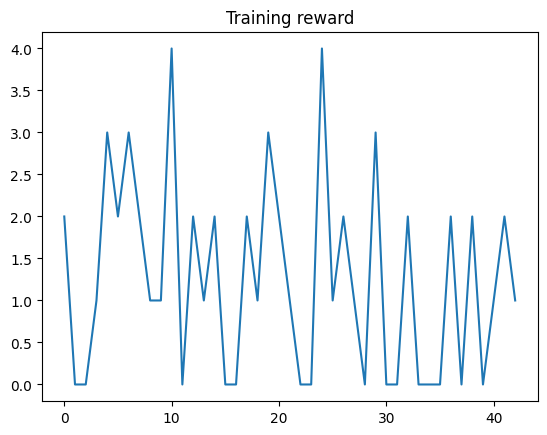

In [84]:
# plt.title("Training reward")
# plt.plot(range(0, len(rewards)*LOG_FREQ, LOG_FREQ), rewards)
# plt.savefig("breakout_dqn_5100000_rewards.png")

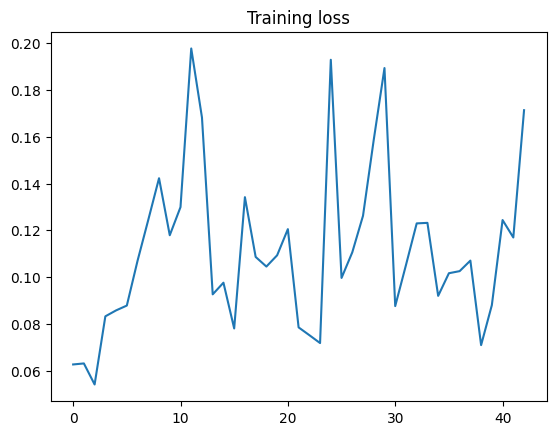

In [85]:
# plt.title("Training loss")
# plt.plot(range(0, len(losses)*LOG_FREQ, LOG_FREQ), losses)
# plt.savefig("breakout_dqn_5100000_loss.png")

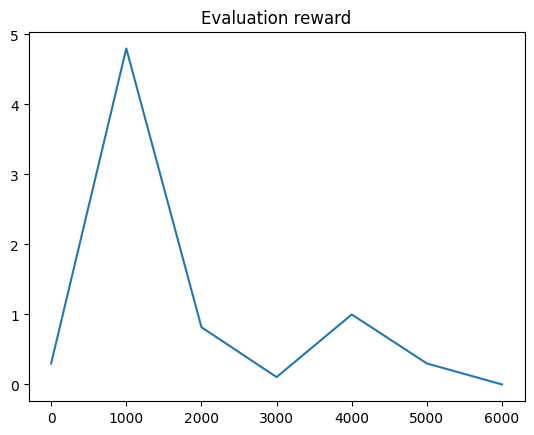

In [86]:
# plt.title("Evaluation reward")
# plt.plot(range(0, len(eval_rewards)*EVAL_FREQ, EVAL_FREQ), eval_rewards)

### Save model

In [14]:
with open('breakout_wtarget_dqn.pt', 'wb') as f:
    torch.save(model.state_dict(), f)